# Приоритизация гипотез. А/В тест

## Описание исследования

**Цель:**
- приоритизировать гипотезы (список гипотез для увеличения выручки был подготовлен совместно с отделом маркетинга)
- проанализировать результаты А/В теста и принять решение о гипотезе

**Описание данных для анализа:**

Список гипотез
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале (*чем больше значение Efforts, тем дороже проверка гипотезы*)

Данные о заказах пользователей в интернет-магазине:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Данные о посещениях интернет-магазина пользователями:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Обзор и подготовка данных для анализа

In [5]:
import pandas as pd
import numpy as np
from scipy import stats as st
from datetime import datetime as dt
from matplotlib import pyplot as plt

In [6]:
hypothesis = pd.read_csv('D:/учеба/портфолио/roots/ab/hypothesis.csv')
orders = pd.read_csv('D:/учеба/портфолио/roots/ab/orders.csv')
visitors = pd.read_csv('D:/учеба/портфолио/roots/ab/visitors.csv')

In [7]:
# функция для предварительного обзора данных
def preview (data):
    print('Посмотрим на данные')
    print('-'*50)
    display(data.head())
    print('Атрибуты')
    print('-'*50)
    print(data.info())
    print('Пропусков в данных')
    print('-'*50)
    print(data.isna().sum())
    print('Полных дубликатов в данных')
    print('-'*50)
    print(data.duplicated().sum())

### Таблица hypothesis/Гипотезы

In [8]:
preview(hypothesis)

Посмотрим на данные
--------------------------------------------------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Атрибуты
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
Пропусков в данных
--------------------------------------------------
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
Полных дубликатов в данных
--------------------------------------------------
0


In [9]:
# поправим названия столбцов
hypothesis = hypothesis.rename(
    columns = {'Hypothesis':'hypothesis', 'Reach':'reach', 'Impact':'impact', 'Confidence':'confidence', 'Efforts':'efforts'}
)

### Таблица orders/Заказы

In [10]:
preview(orders)

Посмотрим на данные
--------------------------------------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Атрибуты
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
Пропусков в данных
--------------------------------------------------
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
Полных дубликатов в данных
--------------------------------------------------
0


In [11]:
# поравим нахвания столбцов
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id' })

In [12]:
# приведем к нужному типу даты
orders['date'] = pd.to_datetime(orders['date'])

### Таблица visitors/посещения

In [13]:
preview(visitors)

Посмотрим на данные
--------------------------------------------------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Атрибуты
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
Пропусков в данных
--------------------------------------------------
date        0
group       0
visitors    0
dtype: int64
Полных дубликатов в данных
--------------------------------------------------
0


In [14]:
# приведем к нужному типу даты
visitors['date'] = pd.to_datetime(visitors['date'])

In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Выводы

Данные чистые: дубликатов и пропусков нет. Поправили названия столбцов, привели к нужному типу даты. Проверку на пересекающихся пользователей проведем перед началом АВ-теста.

## Приоритизация гипотез

In [16]:
# разработанные гипотезы
for x in hypothesis['hypothesis']:
    print(x)

Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
Запустить собственную службу доставки, что сократит срок доставки заказов
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
Запустить акцию, дающую скидку на товар в день рождения


In [17]:
# оценки гипотез для приоритизации 
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Посмотрим на гипотезы, получившие максимальные оценки по критериям в отдельности:
- Лишь одна гипотеза **"Запустить собственную службу доставки"** выходит за рамки - назовем упрощенно - "работы с приложением", и требует соответственно привлечения бОльших ресурсов компании (критерий дороговизны - efforts).
- Гипотеза **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"** охватит по нашим оценкам всех пользователей (критерий охвата - reach)
- Гипотезы **"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"** и **"Запустить акцию, дающую скидку на товар в день рождения"** - максимально повлияют на пользователей (критерий влияния - impact)
- в 4 гипотезах мы уверены больше (критерий уверенности - confidence):**"Запустить акцию, дающую скидку на товар в день рождения", "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию", "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"**

### Оценка гипотез по фреймвору ICE 

Чтобы выбрать гипотезу для А/В теста прменим фреймворк ICE

In [18]:
hypothesis['ice_score'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='ice_score', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice_score
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000


В лидеры по критериям охват-влияние-"затратность" вышла гипотеза - **"Запустить акцию, дающую скидку на товар в день рождения"**

Но мы не учли критерий охвата пользователей, а для этой гипотезы, по нашим оценкам, охват самый маленький (что связано с выборкой пользователй для акции по их дням рождения).


### Оценка гипотез по фреймвору RICE

Применим для приоритизации фреймворк RICE, учитывающий охват, и посмотрим результаты.

In [50]:
hypothesis['rice_score'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(['ice_score','rice_score'], ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


### Вывод

За счет наивысшей оценки по критерию охвата аудитории первой для проверки стала гипотеза - **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"**.

## A/B-тест

### Исследовательский анализ

Предварительно внимательнее посмотрим на наши данные.

Orders - таблица с заказами интернет-магазина:
- проверим все ли уникальные пользователи находятся в какой-либо одной группе (контрольной или тестовой) или есть те, кто попал в обе
- посмотрим за какие дни данные в нашей таблице,
- назовем максимальную и минимальную зафиксированную выручку.

In [20]:
# проверяем есть ли пользователи попавшие и в контрольную, и в тестовую группы
test = orders.groupby('visitor_id')['group'].nunique().reset_index().query('group > 1')
display(test.head()), len(test)/orders['visitor_id'].nunique()

,visitor_id,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


(None, 0.05625606207565471)

In [21]:
# такие пользователи есть, их доля в датасете 5 %, удалим их

orders_new = orders.set_index('visitor_id').drop(list(test['visitor_id']), axis=0).reset_index()

# проверим удаление
len(orders_new.groupby('visitor_id')['group'].nunique().reset_index().query('group > 1'))

0

In [22]:
# выручка с заказа минимум, максимум
orders_new['revenue'].agg({'min','max'})

max    1294500
min         50
Name: revenue, dtype: int64

In [23]:
# временной диапазон
orders_new['date'].agg({'max','min'})

max   2019-08-31
min   2019-08-01
Name: date, dtype: datetime64[ns]

#### Таблица orders - итоги

**Мы видим ощутимый разброс в выручке от заказов от 50 руб до 1294500 руб., время проведения А/В теста - август 2019 года, были выявлены и удалены из данных пользователи, которые попали в контрольную и тестовую группу одновременно(таких пользователей 58, 5% от общего числа уникальных пользователей в данных с заказами). Наличие пересекающихся пользователей в датасете говорит о том, что подготовлен тест был недостаточно хорошо, и к его результатам нужно отнестись осторожно.**

Visitors - таблица с данными о визитах пользователей по датам:
- проверим временной период для данных,
- назовем максимальное и минимальное количество визитов в день по общим данным


In [24]:
# временной диапазон
visitors['date'].agg({'max','min'})

max   2019-08-31
min   2019-08-01
Name: date, dtype: datetime64[ns]

In [25]:
# визитов в день
visitors['visitors'].agg({'max','min'})

max    770
min    361
Name: visitors, dtype: int64

In [26]:
# проверка разделения информации по группам
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

####  Таблица visitors - итоги

**Время проведение А/В теста совпадает с данными таблицы заказов - август 2019 года, максимальное количество зафиксированных посещений 770, минимальное - 361. В данных по 31 записи для группы А и столько же для группы В (по количеству дней в августе)**

### Кумулятивные данные

Соберем кумулятивные данные

In [27]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders_new[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_agg = dates_groups.apply(
    lambda x: orders_new[np.logical_and(orders_new['date'] <= x['date'], orders_new['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}
    ),
    axis=1
).sort_values(by=['date','group'])
            

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_agg = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1
).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_agg.merge(visitors_agg, on=['date', 'group'], how='left')
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# конверсия
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']


cumulative_data.head()


,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.031390
3,2019-08-02,B,40,39,221801,1294,0.030912
4,2019-08-03,A,66,60,346854,1845,0.035772


Данные в cumulative_data:
- date - дата
- group - группа
- orders - заказов с накоплением на указанную дату
- buyers - покупателей с накоплением на указанную дату
- revenue - выручка с накоплением на указанную дату
- visitors - посещений интернет-магазина с накоплением на указанную дату
- conversion - конверсия посещений в заказы

#### Кумулятивная выручка по группам

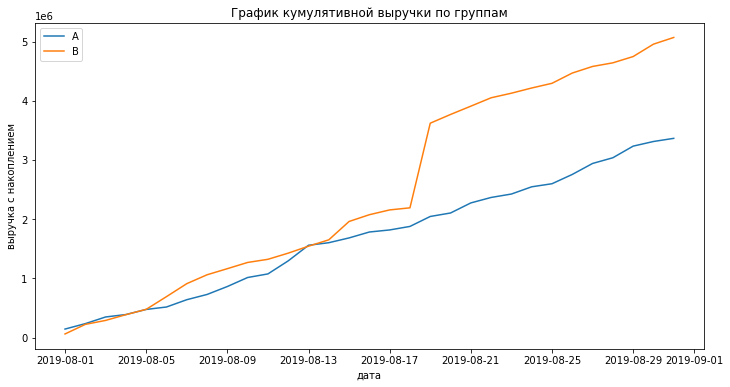

In [28]:
# кумулятивнoe количество заказов и кумулятивная выручка по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders', 'conversion']]

# кумулятивнoe количество заказов и кумулятивная выручка по дням в группе В
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders', 'conversion']]

# задаем размер графика
plt.figure(figsize=(12, 6))

#строим графики выручки
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('дата')
plt.ylabel('выручка с накоплением')
plt.show()



- Выручка равномерно увеличивается в группе А.
- В группе В выручка чуть лучше и также равноменрно растет до 18 августа, затем резко повышается относительно группы А и продолжает дальше расти равномерно.

Рост выручки в обеих группах хороший показатель, резкое повышение в группе В может говорить о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке (один такой у нас точно есть - заказ на 1294500 руб). Выбросы в дальнейшем проанализируем.

#### Кумулятивный средний чек

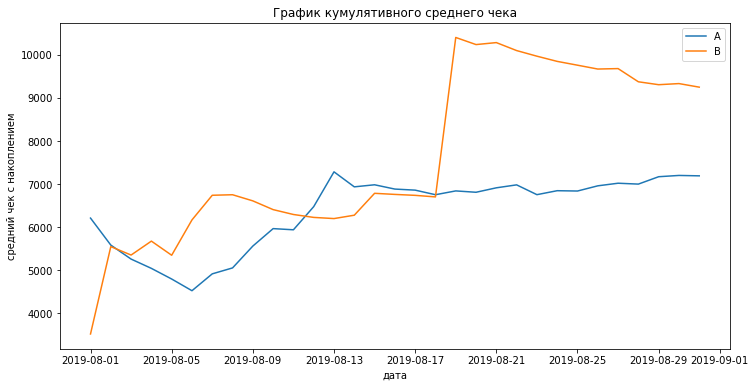

In [29]:
# задаем размер графика
plt.figure(figsize=(12, 6))

#график кумулятивного среднего чека по группам
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'] / cumulative_revenue_A['orders'],  label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'] / cumulative_revenue_B['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека')
plt.xlabel('дата')
plt.ylabel('средний чек с накоплением')
plt.show()

В среднем чеке с накоплением похожая картина:
- до 14-15 августа показатель нестабилен в обеих группах, к 18 августа группы примерно уравниваются
- после 18 августа группа А стабилизируется на примерно 7000 рублей, в группе В резкий всплеск до более 10000 рублей (скорее всего это влияние максимальный заказа на сумму более 1 миллиона рублей) - далее группа В продолжает лидировать, но намечена тенденция к снижению среднего чека (таких крупных заказов, скорее всего далее уже не было - проверим это предположение в дальнейшем анализе) 

#### Относительное изменение кумулятивного среднего чека группы B к группе A

In [30]:
# объединяем таблицы с нужными данными
cumulative_merge = cumulative_revenue_A.merge(cumulative_revenue_B, on='date', how='left', suffixes=['_A', '_B'])
cumulative_merge.head()

,date,revenue_A,orders_A,conversion_A,revenue_B,orders_B,conversion_B
0,2019-08-01,142779,23,0.031989,59758,17,0.023843
1,2019-08-02,234381,42,0.031390,221801,40,0.030912
2,2019-08-03,346854,66,0.035772,288850,54,0.029950
3,2019-08-04,388030,77,0.030055,385740,68,0.026428
4,2019-08-05,474413,99,0.029837,475648,89,0.027134


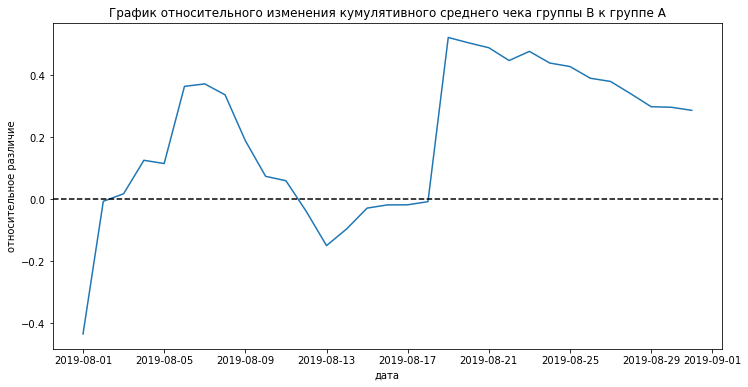

In [31]:
# задаем размер графика
plt.figure(figsize=(12, 6))

#  строим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.plot(
    cumulative_merge['date'], (
        cumulative_merge['revenue_B']/cumulative_merge['orders_B']
    ) / (
    cumulative_merge['revenue_A']/cumulative_merge['orders_A']
    ) - 1
)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')
plt.ylabel('относительное различие')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Видим резкие скачки - скорее всего влияние аномальных данных (посмотрим их позднее), группа В в начале и середине времени теста проигрывала группе А, но большую часть времени теста - все же значительно превосходила группу А, после 18 августа средний чек снизижался и далее либо зафиксируется, либо будет снижаться дальше 

#### Кумулятивная конверсия по группам

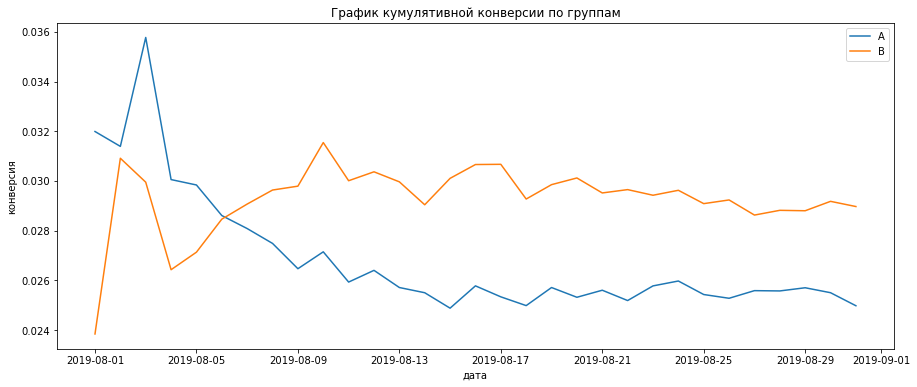

In [32]:
# задаем размер графика
plt.figure(figsize=(15, 6))


#строим график конверсии
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['conversion'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['conversion'], label='B')

plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('дата')
plt.ylabel('конверсия')
plt.show()

Группы колебались около одного значения, но затем конверсия группы В вышла вперёд и зафиксировалась, а конверсия группы А просела и продолжает снижаться

#### Относительное изменение кумулятивной конверсии группы B к группе A

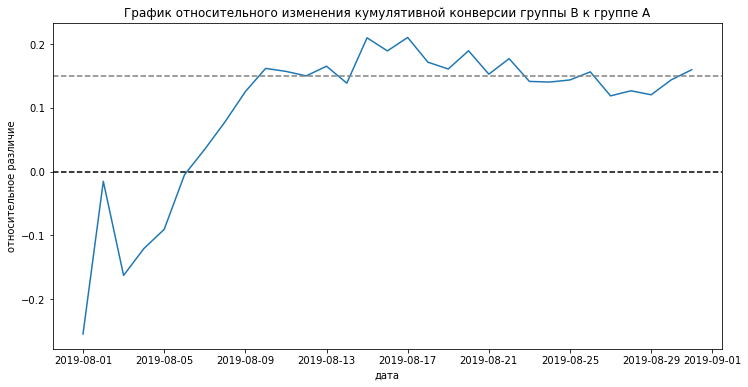

In [33]:
# задаем размер графика
plt.figure(figsize=(12, 6))

#  строим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.plot(
    cumulative_merge['date'], cumulative_merge['conversion_B'] / cumulative_merge['conversion_A']  - 1
)

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('дата')
plt.ylabel('относительное различие')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.show()

Сначала группа В проигрывала группе А, но затем вышла заметно вперед, зафиксировалась и наблюдается тенденция к дальнейшему увеличению относительной разницы между группами в пользу группы В.

#### Выводы

В целом мы видим, что показатели группы В превосходят показатели группы А по всем кумулятивным метрикам: они уже либо зафиксировались, либо имеют тенденцию к росту. Исключение - средний чек, его показатели в группе В хоть и лучше - но все же показывают тенденцию к снижению - причиной тому скорее всего аномальные суммы некоторых заказов.

### Анализ аномалий и расчет границ "нормальных данных"

#### Заказы

Построим точечный график количества заказов по пользователям

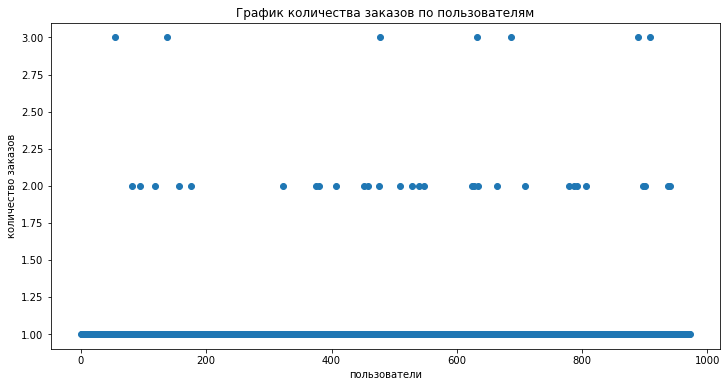

In [34]:
# сгруппируем заказы по пользователям и посчитаем количество уникальных заказов
orders_by_user = orders_new.groupby('visitor_id').agg({'transaction_id':'nunique'}).reset_index()
orders_by_user.columns = ['user_id', 'order']

# задаем размер графика
plt.figure(figsize=(12, 6))

#строим график
x_values = pd.Series(range(0, len(orders_by_user)))

plt.scatter(x_values, orders_by_user['order'])

plt.title('График количества заказов по пользователям')
plt.xlabel('пользователи')
plt.ylabel('количество заказов')
plt.show()

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [35]:
print(np.percentile(orders_by_user['order'], [90,95,99]))

[1. 1. 2.]


График приобрел "линейный" вид. Не более 1% пользователей делают более чем 2 заказа. Большая часть пользователей делает 1 заказ за короткое время. Примем, что аномальным будет количество заказов более  или равное 2 на 1 пользователя.

#### Стоимость заказов

Построим точечный график стоимостей заказов.

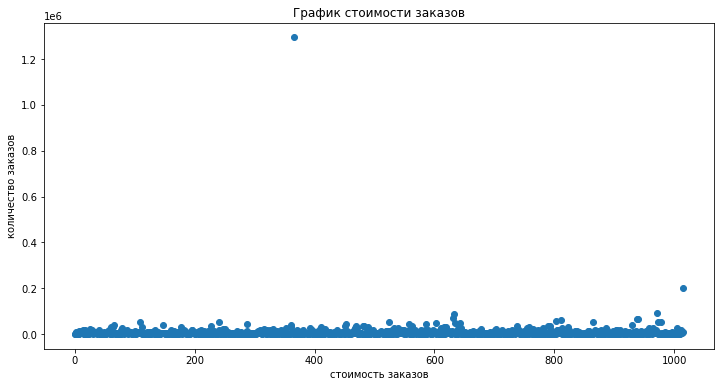

In [53]:
# задаем размер графика
plt.figure(figsize=(12, 6))

x_values = pd.Series(range(0, len(orders_new)))

plt.scatter(x_values, orders_new['revenue'])

plt.title('График стоимости заказов')
plt.xlabel('стоимость заказов')
plt.ylabel('количество заказов')
plt.show()

Вот мы и увидели наш заказ свыше 1200000 рублей, еще один крупный заказ - около 200000 рублей, остальные заказы расположены достаточно плотно в границах, примерно, от 0 до 50000 рублей. 

Посчитаем точно, заказы на какие суммы делает большинство пользователей

In [37]:
print(np.percentile(orders['revenue'], [90,95,99]))

[18168.  28000.  58233.2]


90% заказов дешевле 18168 рублей. Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей. Примем что аномальная сумма заказов - 28000 руб. и больше.

#### Выводы

К аномальным значениям в дальнейшем анализе отнесем:
- количество заказов более 2 на 1 пользователя
- сумму заказза более 28000 рублей

### Проверяем статистическую значимость

#### Статистическая значимость по "сырым" данным

##### Статистическая значимость различий в конверсии

Гипотезы:
- Н0 - Конверсии в двух группах равны
- Н1 - Конверсии групп не равны

Для проверки гипотезы здесь и далее будем использовать непараметрический тест Манна-Уитни для выборок подверженных влиянию выбросов(аномалий)

In [38]:
# подготовим данные
# сгруппируем количество заказов по пользователям
orders_by_users_A = orders_new[orders_new['group'] == 'A'].groupby(
    'visitor_id', as_index = False
).agg({'transaction_id':'nunique'})
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = orders_new[orders_new['group'] == 'B'].groupby(
    'visitor_id', as_index = False
).agg({'transaction_id':'nunique'})
orders_by_users_B.columns = ['user_id', 'orders']

# посчитаем сумму заказов пользователей в день по группам
visitors_per_date_A = visitors[visitors['group'] == 'A'].groupby('date')['visitors'].sum()
visitors_per_date_B = visitors[visitors['group'] == 'B'].groupby('date')['visitors'].sum()

# сформируем выборки по группам
# объединим в объект Series количество заказов
# добавим 0 количеству пользователей не сделавшим ни одного заказа
# их количество найдем так: visitors_per_date_A.sum() - len(orders_by_users_A['orders']
sample_A = pd.concat(
    [orders_by_users_A['orders'], pd.Series(
        0, index=np.arange(visitors_per_date_A.sum() - len(orders_by_users_A['orders'])
                          ), name='orders')], axis=0
)

sample_B = pd.concat(
    [orders_by_users_B['orders'], pd.Series(
        0, index=np.arange(visitors_per_date_B.sum() - len(orders_by_users_B['orders'])
                          ), name='orders')], axis=0
)

In [39]:
# проведем тест
alpha = .05
results = st.mannwhitneyu(sample_A, sample_B)
print('р-значение:', '{0:.5f}'.format(results.pvalue))
if results.pvalue < alpha:
   print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя')
           
print( 'Относительное различие конверсий:','{0:.3f}'.format(sample_B.mean()/sample_A.mean() - 1))


р-значение: 0.01102
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие конверсий: 0.160


**По "сырым" данным есть разница конверсий между двумя группами. При этом относительный выигрыш группы В 16%**

##### Cтатистическая значимость различий в среднем чеке

Гипотезы:
- Н0 - Средний чек в двух группах равен
- Н1 - Средний чек в группах не равен

In [40]:
# проводим тест
results = st.mannwhitneyu(orders_new[orders_new['group'] =='A']['revenue'], orders_new[orders_new['group'] =='B']['revenue'])
print('р-значение:', '{0:.5f}'.format(results.pvalue))
if results.pvalue < alpha:
   print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя')
           
# считаем относительное различие среднего чека
print(
    'Относительное различие среднего чека:', '{0:.3f}'.format(
        orders_new[orders_new['group'] =='B']['revenue'].mean()/orders_new[orders_new['group'] =='A']['revenue'].mean() - 1
    )
)


р-значение: 0.82949
Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя
Относительное различие среднего чека: 0.287


**По "сырым" данным вывод о различии среднего чека в двух группах сделать нельзя, но при этом по средний чек группы В значимо превосходит средний чек группы А.**

#### Статистическая значимость по "очищенным" данным

In [41]:
# собираем пользователей, сделавших более 2 заказов
users_with_many_orders = pd.concat(
    [orders_by_users_A[orders_by_users_A['orders'] >= 2]['user_id'], 
     orders_by_users_B[orders_by_users_B['orders'] >= 2]['user_id']
    ], axis=0
)

# собираем пользователей, сделавших заказ на сумму более 28000 рублей
users_with_expencive_orders = orders_new[orders_new['revenue'] > 28000]['visitor_id']

# объединяем итоги
abnormal_users = pd.concat([users_with_many_orders, users_with_expencive_orders],axis=0).drop_duplicates().sort_values()

# сколько пользователей отсечем далее
len(abnormal_users)

83

##### Статистическая значимость различий в конверсии

Гипотезы:
- Н0 - Конверсии в двух группах равны
- Н1 - Конверсии групп не равны

In [42]:
# фильтруем выборку для группы А, оставляем "нормальные" данные
sample_A_filtered = pd.concat(
    [orders_by_users_A[
        np.logical_not(orders_by_users_A['user_id'].isin(abnormal_users))
    ]['orders'], pd.Series(
        0, index=np.arange(visitors_per_date_A.sum() - len(orders_by_users_A['orders'])
                          ), name='orders')], axis=0
)

# фильтруем выборку для группы B, оставляем "нормальные" данные
sample_B_filtered = pd.concat(
    [orders_by_users_B[
        np.logical_not(orders_by_users_B['user_id'].isin(abnormal_users))
    ]['orders'], pd.Series(
        0, index=np.arange(visitors_per_date_B.sum() - len(orders_by_users_B['orders'])
                          ), name='orders')], axis=0
)


In [43]:
# проведем тест
alpha = .05
results = st.mannwhitneyu(sample_A_filtered, sample_B_filtered)
print('р-значение:', '{0:.5f}'.format(results.pvalue))
if results.pvalue < alpha:
   print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя')
           
print( 'Относительное различие конверсий:','{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean() - 1))


р-значение: 0.01223
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие конверсий: 0.181


**По очищенным данным мы также видим статистически значимую разницу конверсий между группами, относительный выигрыш группы В даже увеличился с 16% до 18%**

##### Статистическая значимость различий в среднем чеке 

Гипотезы:

Н0 - Средний чек в двух группах равен
Н1 - Средний чек в группах не равен

In [44]:
# предварительно посмотрим в какую группу попали те два самых больших заказа
orders_new[orders_new['revenue'] > 100000]

,visitor_id,transaction_id,date,revenue,group
365,1920142716,590470918,2019-08-19,1294500,B
1015,2108080724,3936777065,2019-08-15,202740,B


In [45]:
# проводим тест
results = st.mannwhitneyu(
    orders_new[np.logical_and(orders_new['group'] =='A', np.logical_not(orders_new['visitor_id'].isin(abnormal_users))
    )]['revenue'], orders_new[np.logical_and(orders_new['group'] =='B', np.logical_not(orders_new['visitor_id'].isin(abnormal_users))
    )]['revenue']
)

print('р-значение:', '{0:.5f}'.format(results.pvalue))
if results.pvalue < alpha:
   print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя')
           
# считаем относительное различие среднего чека
print(
    'Относительное различие среднего чека:', '{0:.3f}'.format(
        orders_new[np.logical_and(orders_new['group'] =='B', np.logical_not(orders_new['visitor_id'].isin(abnormal_users))
    )]['revenue'].mean()/ orders_new[np.logical_and(orders_new['group'] =='A', np.logical_not(orders_new['visitor_id'].isin(abnormal_users))
    )]['revenue'].mean() - 1
    )
)


р-значение: 0.85100
Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя
Относительное различие среднего чека: -0.006


- **Вывод о статистически значимом различии среднего чека даже по очищенным данным сделать нельзя**
- **После очистки данных от аномально высоких сумм заказов (две крупные аномалии попали в группу В) - относительная разница средних чеков между группами предсказуемо сместилась и даже стала менее чем на 1% в пользу контрольной группы А **

**Примем, что в итоге средний чек между группами не показал статистическую значимость, позволяющую судить о разнице групп, кроме того его показатели нестабильны и колеблются, хотя относительное различие практически незаметно**

## Выводы

Имеющиеся после анализа результаты:
- Есть статистически значимое различие по конверсии между группами как по "сырым" данным, так и после фильтрации аномалий. Относительная разница показала выигрыш группы В, и после фильтрации выигрыш даже увеличилась с 16% до 18%

- Вывод о статистически значимом различии среднего чека ни по "сырым" ни по очищенным данным сделать нельзя.

- График различия конверсии между группами показал, что группа В вышла заметно вперед, зафиксировалась и наблюдается тенденция к дальнейшему увеличению относительной разницы между группами или ее стабилизации в пользу группы В.
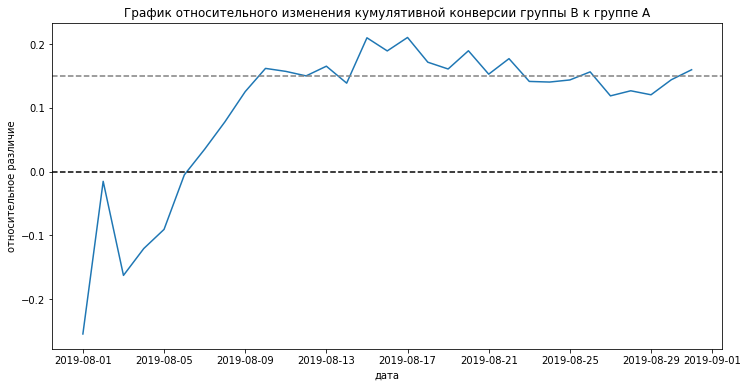

- График различия среднего чека колеблется: он-то и позволил вам найти аномалии. Сделать из этого графика определённые выводы нельзя. Хотя нужно заметить, что после очистки от двух крупных аномальных заказов, попавших именно в группу В, по относительной разнице совсем незначительно менее чем на 1 % вперед вышла группа А
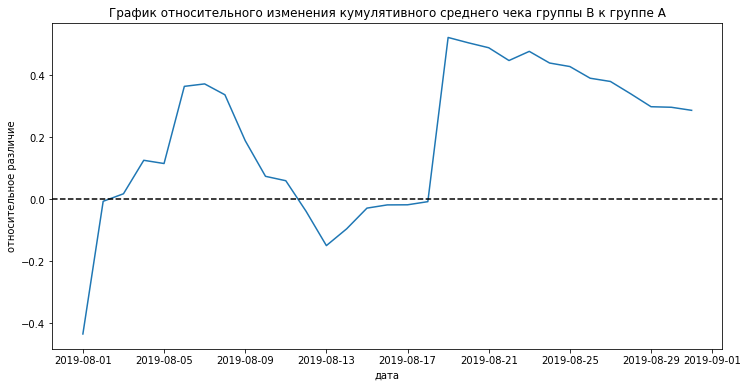

Несмотря на нестабильность метрики среднего чека, зафиксированные статистически значимые отличия в конверсии позволяют нам:

**1.** Принять следующее решение: **признать победу группы В и остановить тест**

**2.** Рекомендовать далее **разработать/отобрать гипотезы, нацеленные на увеличение среднего чека, приоритизировать их и по возможности начать проверять**